In [72]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from ISLP import load_data

from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, cut_tree, linkage
from ISLP.cluster import compute_linkage

## 12.5 Lab: Unsupervised Learning

### 15.5.1 Principal Components Analysis

We perform PCA on `USArrests`. Because this dataset is from the `R` computing environment, we use `get_rdataset()`.

This data set contains statistics, in arrests per 100,000 residents for assault, murder, and rape in each of the 50 US states in 1973. Also given is the percent of the population living in urban areas.

[RDocumentation](https://www.rdocumentation.org/packages/datasets/versions/3.6.2/topics/USArrests)

In [3]:
USArrests = get_rdataset('USArrests').data
USArrests.head(10)

,Murder,Assault,UrbanPop,Rape
rownames,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6
Colorado,7.9,204,78,38.7
Connecticut,3.3,110,77,11.1
Delaware,5.9,238,72,15.8
Florida,15.4,335,80,31.9


In [4]:
USArrests.var()

Murder        18.970465
Assault     6945.165714
UrbanPop     209.518776
Rape          87.729159
dtype: float64

Because PCA looks for derived variables that account for most of the variance in dataset, if we do not scale the variables first, then the principal components will be mostly driven by `Assault`.

In [5]:
scaler = StandardScaler(
    with_std=True,
    with_mean=True
)
USArrests_scaled = scaler.fit_transform(USArrests)

Having scaled the data, we can now perform PCA using `PCA()` from the `sklearn.decomposition` package.

In [11]:
pcaUS = PCA()
pcaUS.fit(USArrests_scaled)

PCA()

The scores can be computed using the `transform()` method of `pcaUS` after it has been fit.

In [13]:
scores = pcaUS.transform(USArrests_scaled)

The `components_` attribute provides the principal component loadings: each row of `pcaUS.components_` contains the corresponding principal component loading vector.

In [14]:
pcaUS.components_

array([[ 0.53589947,  0.58318363,  0.27819087,  0.54343209],
       [ 0.41818087,  0.1879856 , -0.87280619, -0.16731864],
       [-0.34123273, -0.26814843, -0.37801579,  0.81777791],
       [ 0.6492278 , -0.74340748,  0.13387773,  0.08902432]])

Here, we make a simple biplot (showing the principal component scores and principal component loadings) to visualise the PCA:

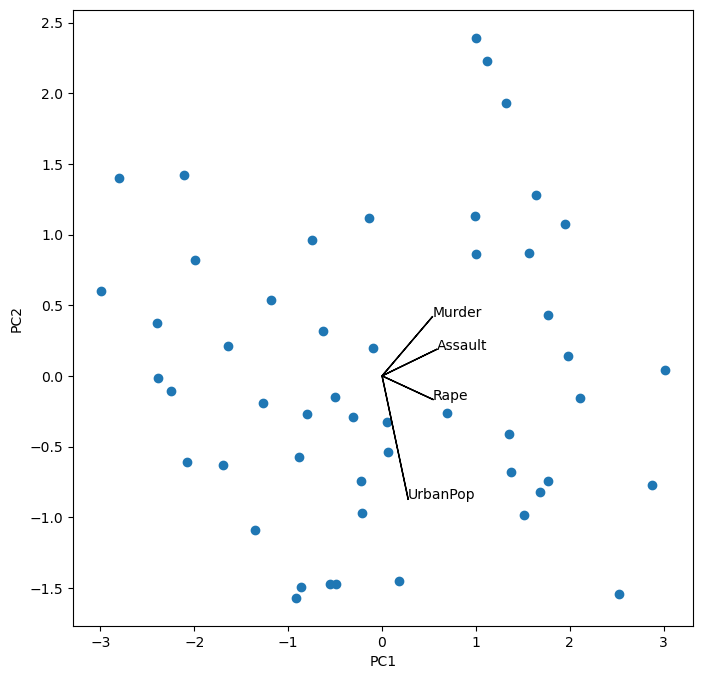

In [15]:
i, j = 0, 1 # We're looking at the first two components
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.scatter(scores[:, 0], scores[:,1])
ax.set_xlabel('PC%d' % (i + 1))
ax.set_ylabel('PC%d' % (j + 1))
for k in range(pcaUS.components_.shape[1]):
    ax.arrow(0, 0, pcaUS.components_[i, k], pcaUS.components_[j, k])
    ax.text(
        pcaUS.components_[i, k],
        pcaUS.components_[j, k],
        USArrests.columns[k]
    )

We can reproduce the figure from the textbook chapter by flipping the sign of the second component and increating the length of the arrows to emphasise the loadings:

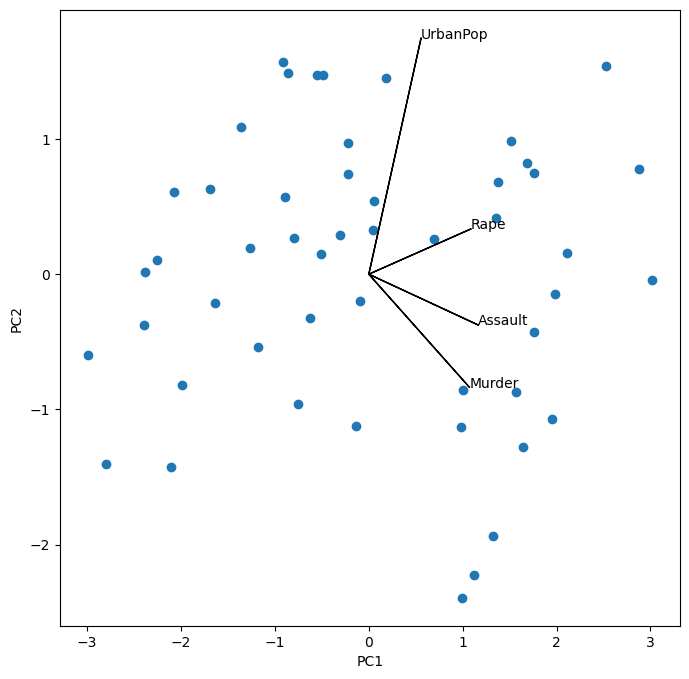

In [18]:
s_ = 2 # Scale factor for arrows
scores[:, 1] *= -1
pcaUS.components_[1] *= -1 # Flip the y-axis
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.scatter(scores[:, 0], scores[:,1])
ax.set_xlabel('PC%d' % (i + 1))
ax.set_ylabel('PC%d' % (j + 1))
for k in range(pcaUS.components_.shape[1]):
    ax.arrow(0, 0, s_*pcaUS.components_[i, k], s_*pcaUS.components_[j, k])
    ax.text(
        s_*pcaUS.components_[i, k],
        s_*pcaUS.components_[j, k],
        USArrests.columns[k]
    )

The standard deviations of the principal component scores are:

In [19]:
scores.std(0, ddof=1)

array([1.5908673 , 1.00496987, 0.6031915 , 0.4206774 ])

The explained variance in the data by each component can be extracted:

In [25]:
pcaUS.explained_variance_

array([2.53085875, 1.00996444, 0.36383998, 0.17696948])

as can the _proportion_ of variance explained by each component:

In [26]:
pcaUS.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

We see that `PCA1` accounts for 62.0% of the variance in the data, while `PCA2` accounts for 24.7%.

We can plot a scree plot depicting the proportion of the variance explained by each component:

In [29]:
%%capture 
# ^ Supresses display of a partially-complete figure
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ticks = np.arange(pcaUS.n_components_) + 1
ax = axes[0]
ax.plot(
    ticks,
    pcaUS.explained_variance_ratio_,
    marker='o'
)
ax.set_xlabel('Principal Component')
ax.set_ylabel('Proportion of Variance Explained')
ax.set_ylim([0, 1])
ax.set_xticks(ticks)

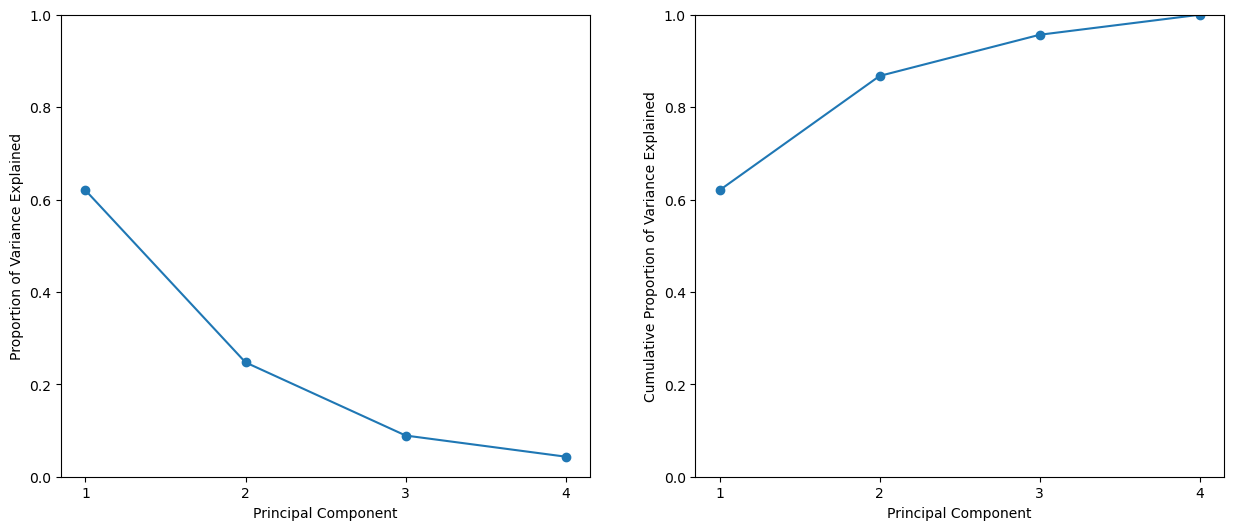

In [30]:
ax = axes[1]
ax.plot(
    ticks,
    pcaUS.explained_variance_ratio_.cumsum(), # computes culumative sum of elements of vector
    marker='o'
)
ax.set_xlabel('Principal Component')
ax.set_ylabel('Cumulative Proportion of Variance Explained')
ax.set_ylim([0, 1])
ax.set_xticks(ticks)
fig

### 12.5.2 Matrix Completion

It turns out that performing singular value decomposition on a scaled and centered data matrix is equivalent to conputing the first M principal components of the data:

In [32]:
X = USArrests_scaled
U, D, V = np.linalg.svd(X, full_matrices=False)
U.shape, D.shape, V.shape

((50, 4), (4,), (4, 4))

The matrix `V` is equivalent to the loading matrix from principal components (with the sign flipped). Using the `full_matrices=False` option ensures that for a tall matrix the shape of `U` is the same as the shape of `X`.

In [33]:
V

array([[-0.53589947, -0.58318363, -0.27819087, -0.54343209],
       [ 0.41818087,  0.1879856 , -0.87280619, -0.16731864],
       [-0.34123273, -0.26814843, -0.37801579,  0.81777791],
       [ 0.6492278 , -0.74340748,  0.13387773,  0.08902432]])

In [34]:
pcaUS.components_

array([[ 0.53589947,  0.58318363,  0.27819087,  0.54343209],
       [-0.41818087, -0.1879856 ,  0.87280619,  0.16731864],
       [-0.34123273, -0.26814843, -0.37801579,  0.81777791],
       [ 0.6492278 , -0.74340748,  0.13387773,  0.08902432]])

The matrix `U` correspondings to a standardised version ofteh PCA score matrix. If we multiply each column of `U` by the corresponding element of `D`, we recover the PCA scores exactly (up to a meaningless sign flip):

In [36]:
(U * D[None, :])[:3]

array([[-0.98556588,  1.13339238, -0.44426879,  0.15626714],
       [-1.95013775,  1.07321326,  2.04000333, -0.43858344],
       [-1.76316354, -0.74595678,  0.05478082, -0.83465292]])

In [37]:
scores[:3]

array([[ 0.98556588, -1.13339238, -0.44426879,  0.15626714],
       [ 1.95013775, -1.07321326,  2.04000333, -0.43858344],
       [ 1.76316354,  0.74595678,  0.05478082, -0.83465292]])

We emit 20 entries in the 50 x 4 matrix at random. We do this by first selecting 20 rows (states) at random, and then selecting one of the four entries in each row at random. This ensures that each row has at least three observed values.

In [51]:
n_omit = 20
np.random.seed(15)
r_idx = np.random.choice(
    np.arange(X.shape[0]),
    n_omit,
    replace=False
)
c_idx = np.random.choice(
    np.arange(X.shape[1]),
    n_omit,
    replace=True
)
Xna = X.copy()
Xna[r_idx, c_idx] = np.nan

We need a function which takes in a matrix and returns an approximation to that matrix using `svd()`.

In [54]:
def low_rank(X, M=1):
    U, D, V = np.linalg.svd(X)
    L = U[:, :M] * D[None, :M]
    return L.dot(V[:M])

We initialise `Xhat` by replacing the missing values with the column means of the non-missing entries. These are stored in `Xbar` before running `np.nanmean()` over the row axis.

In [55]:
Xhat = Xna.copy()
Xbar = np.nanmean(Xhat, axis=0)
Xhat[r_idx, c_idx] = Xbar[c_idx]

We set outselves up to measure the progress of each iteration:

In [57]:
thresh = 1e-7
rel_err = 1
count = 0
ismiss = np.isnan(Xna)
mssold = np.mean(Xhat[~ismiss]**2)
mss0 = np.mean(Xna[~ismiss]**2)

Here, `ismiss` is a logical matrix with the same dimensions as `Xna`. An element is `True` if the corresponding matrix element is missing.

In [61]:
while rel_err > thresh:
    count += 1
    Xapp = low_rank(Xhat, M=1)
    Xhat[ismiss] = Xapp[ismiss]
    mss = np.mean(((Xna - Xapp)[~ismiss])**2)
    rel_err = (mssold - mss) / mss0
    mssold = mss
    print('Iteration: {0}, MSS:{1:.3f}, Rel.Err {2:.2e}'.format(count, mss, rel_err))

Iteration: 1, MSS:0.395, Rel.Err 5.99e-01
Iteration: 2, MSS:0.382, Rel.Err 1.33e-02
Iteration: 3, MSS:0.381, Rel.Err 1.44e-03
Iteration: 4, MSS:0.381, Rel.Err 1.79e-04
Iteration: 5, MSS:0.381, Rel.Err 2.58e-05
Iteration: 6, MSS:0.381, Rel.Err 4.22e-06
Iteration: 7, MSS:0.381, Rel.Err 7.65e-07
Iteration: 8, MSS:0.381, Rel.Err 1.48e-07
Iteration: 9, MSS:0.381, Rel.Err 2.95e-08


After 8 iterations, the relative error falls below the `1e-7` threshold and the algorithm terminates.

We compute the correlation between the 20 imputed values and the actual values:

In [62]:
np.corrcoef(Xapp[ismiss], X[ismiss])[0, 1]

0.711356743429736

Although we implemented matrix competion here for ourselves, in reality, we'd probably use an off-the-shelf package.

### 12.5.3 Clustering

#### K-Means Clustering

We generate sample data where there are two clusters by generating a relative shift between the first and last 25 observations.

In [66]:
X

array([[ 1.76405235,  0.40015721],
       [ 0.97873798,  2.2408932 ],
       [ 1.86755799, -0.97727788],
       [ 0.95008842, -0.15135721],
       [-0.10321885,  0.4105985 ],
       [ 0.14404357,  1.45427351],
       [ 0.76103773,  0.12167502],
       [ 0.44386323,  0.33367433],
       [ 1.49407907, -0.20515826],
       [ 0.3130677 , -0.85409574],
       [-2.55298982,  0.6536186 ],
       [ 0.8644362 , -0.74216502],
       [ 2.26975462, -1.45436567],
       [ 0.04575852, -0.18718385],
       [ 1.53277921,  1.46935877],
       [ 0.15494743,  0.37816252],
       [-0.88778575, -1.98079647],
       [-0.34791215,  0.15634897],
       [ 1.23029068,  1.20237985],
       [-0.38732682, -0.30230275],
       [-1.04855297, -1.42001794],
       [-1.70627019,  1.9507754 ],
       [-0.50965218, -0.4380743 ],
       [-1.25279536,  0.77749036],
       [-1.61389785, -0.21274028],
       [-0.89546656,  0.3869025 ],
       [-0.51080514, -1.18063218],
       [-0.02818223,  0.42833187],
       [ 0.06651722,

In [68]:
np.random.seed(0)
X = np.random.standard_normal((50, 2))
X[:25, 0] += 3;
X[:25, 1] -= 4;

We perform K-means with K = 2:

In [ ]:
kmeans = KMeans(
    n_clusters=2,
    random_state=2,
    n_init=20
).fit(X)

`kmeans.labels_` contains the cluster assignments of the observations:

In [76]:
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

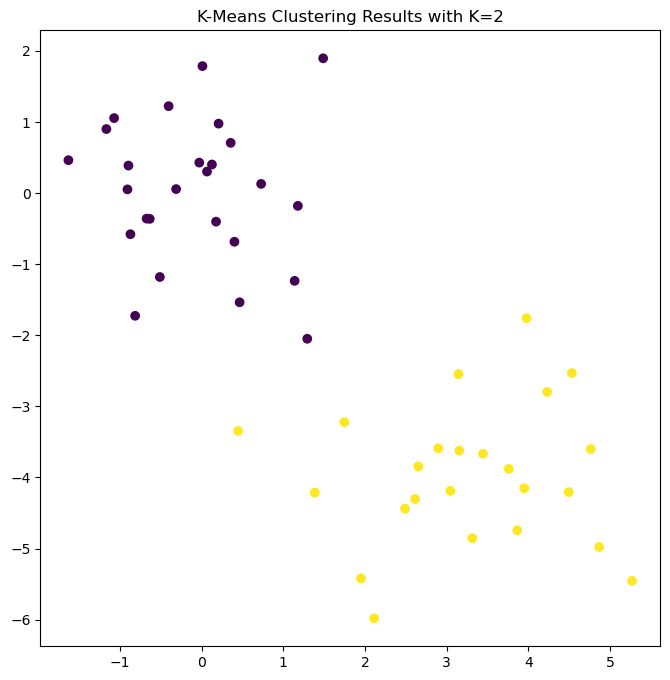

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
ax.set_title('K-Means Clustering Results with K=2');

In this example, we knew ahead of time that there were two clusters because we generated the data. However, we could instead have performed K-means clustering using K = 3:

c:\Users\rich\miniconda3\envs\pydata-book\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


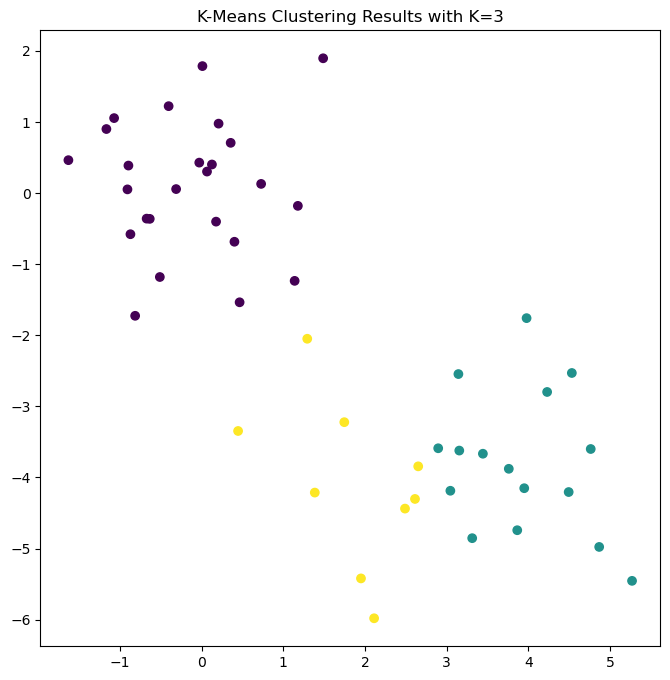

In [80]:
kmeans = KMeans(
    n_clusters=3,
    random_state=3,
    n_init=20
).fit(X)
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
ax.set_title('K-Means Clustering Results with K=3');

`n_init` controls the number of random initial assignments of clusters that K-means tries. Let's compare the inertia (total within-cluster sum of squares which we try to minimise) when using `n_init=1` and `n_init=20`:

In [ ]:
kmeans1 = KMeans(
    n_clusters=3,
    random_state=3,
    n_init=1
).fit(X)

kmeans20 = KMeans(
    n_clusters=3,
    random_state=3,
    n_init=20
).fit(X)

kmeans1.inertia_, kmeans20.inertia_

Setting `n_init` to something high like 20 or 50 will help avoid an undesirable local optimum.

#### Hierarchical Clustering

We use `AgglomerativeClustering()` (aliased as `HClust`) from `sklearn.clustering` to do hierarchical clustering on the same data on which we performed PCA:

In [83]:
HClust = AgglomerativeClustering
hc_comp = HClust(
    distance_threshold=0,
    n_clusters=None,
    linkage='complete'
)
hc_comp.fit(X)

AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        n_clusters=None)

Note: `Complete` is the maximal intercluster dissimilarity. Compute all pairwise
dissimilarities between the observations in cluster A and the observations in cluster B, and record the largest of these dissimilarities.

We use `dendrogram()` from `scipy.cluster.hierarchy` to plot the dendrogram. However, `dendrogram()` expects a _linkage-matrix representation_ of the clustering, which we compute using the `linkage()` function.

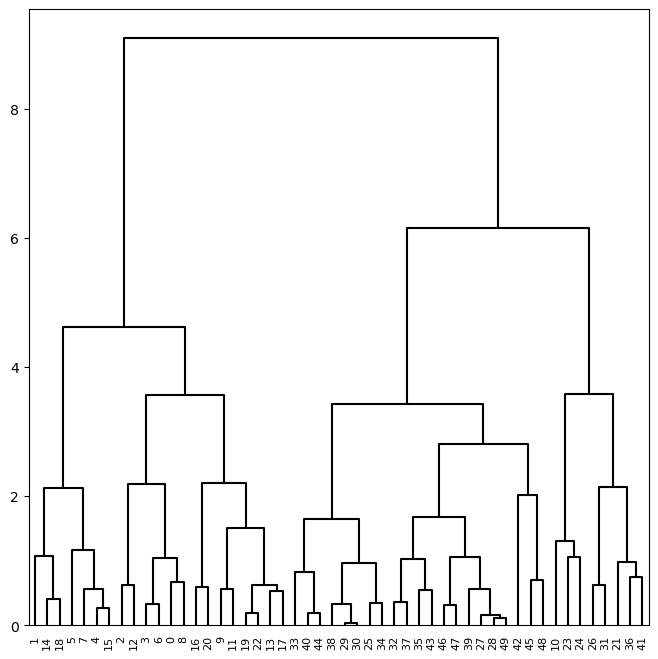

In [96]:
cargs = {
    'color_threshold': -np.inf,
    'above_threshold_color': 'black'
}
linkage_comp = linkage(X, method='complete', metric='euclidean')
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp, ax=ax, **cargs);

We can color branches of the tree above and below the cut-threshold differently by changing `color_threshold`:

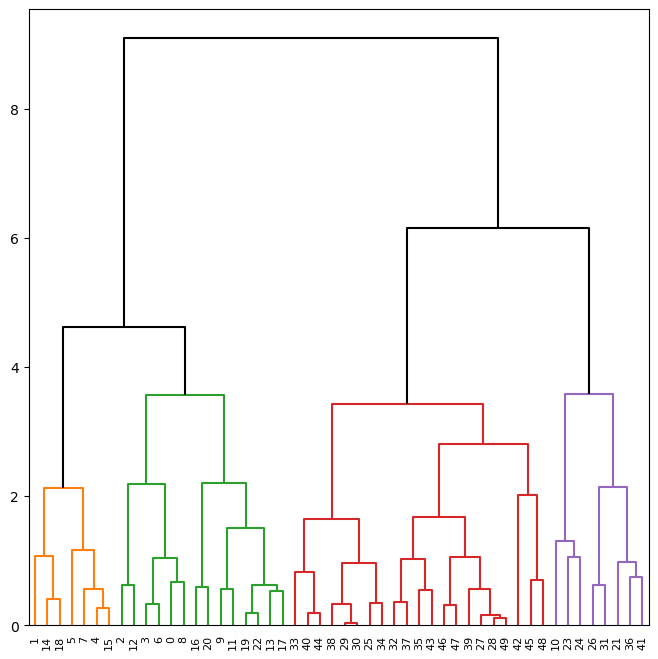

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(
    linkage_comp,
    ax=ax,
    color_threshold=4,
    above_threshold_color='black'
);

We use `cut_tree()` to determine the cluster labels:

In [98]:
cut_tree(linkage_comp, n_clusters=4).T

array([[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 2,
        0, 2, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3,
        3, 3, 3, 3, 3, 3]])

Alternatively, we could have specified a `height` at which to make the cut:

In [100]:
cut_tree(linkage_comp, height=5).T

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2,
        2, 2, 2, 2, 2, 2]])

To scale the variables before performing hierarchical clustering, we can use `StandardScaler()` as we did with PCA:

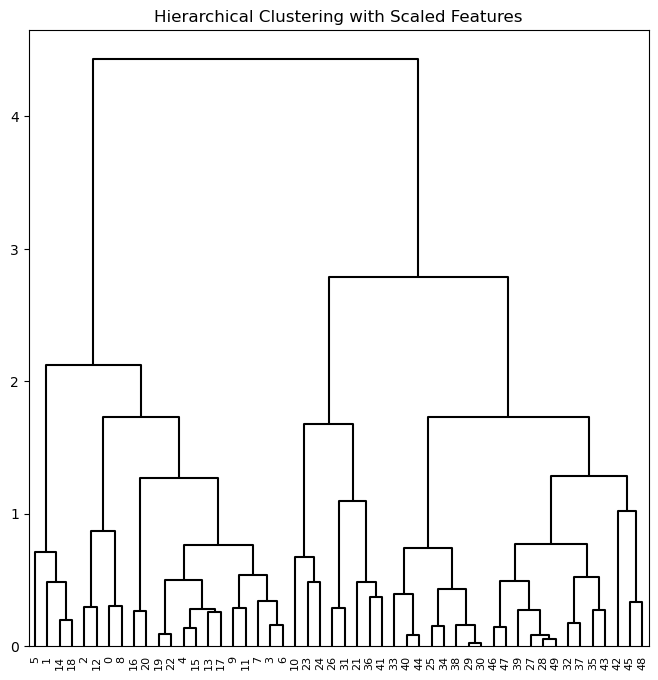

In [104]:
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)
hc_comp_scale = HClust(
    distance_threshold=0,
    n_clusters=None,
    linkage='complete'
).fit(X_scale)
linkage_comp_scale = linkage(X_scale, method='complete', metric='euclidean')
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp_scale, ax=ax, **cargs)
ax.set_title('Hierarchical Clustering with Scaled Features');

Correlation-based distances between observations can be used for clustering. The correlation between two observations measures the similarity of their feature values. With _n_ observations, the _n_ x _n_ correlation matrix can be used as a similarity matrix for clustering.

Note that using correlation only makes sense for data with at least three features since the absolute correlation between any two observations with measurements on two features is always one. Hence, we will cluster a three-dimensional data set

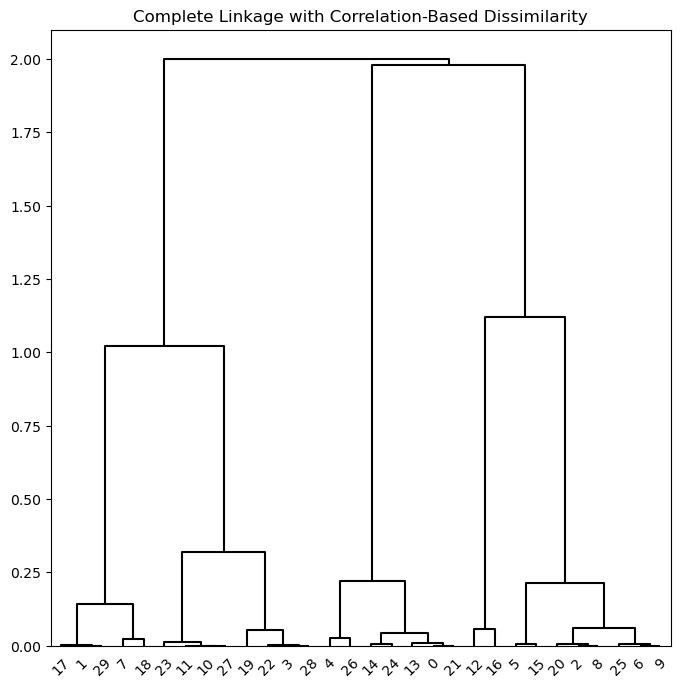

In [121]:
X = np.random.standard_normal((30, 3))
corD = 1 - np.corrcoef(X)
hc_cor = HClust(
    linkage='complete',
    distance_threshold=0,
    n_clusters=None,
    metric='precomputed'
)
hc_cor.fit(corD)
linkage_cor = compute_linkage(hc_cor)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_cor , ax=ax, **cargs)
ax.set_title('Complete Linkage with Correlation-Based Dissimilarity');


### 12.5.4NCI60 Data Example

Unsupervised techniques are often used in the analysis of genomic data. The `NCI60` cancer cell line microarray data consists of 6830 gene expression measurements on 64 cancer cell lines.

In [125]:
NCI60 = load_data('NCI60')
nci_labs = NCI60['labels']
nci_data = NCI60['data']

Each cell line is labeled with a cancer type. After clustering, we will check to see the extent to which the cancer types agree with the clusters.

In [130]:
nci_data.shape

(64, 6830)

In [127]:
nci_labs.value_counts()

label      
NSCLC          9
RENAL          9
MELANOMA       8
BREAST         7
COLON          7
LEUKEMIA       6
OVARIAN        6
CNS            5
PROSTATE       2
K562A-repro    1
K562B-repro    1
MCF7A-repro    1
MCF7D-repro    1
UNKNOWN        1
Name: count, dtype: int64

In [131]:
scaler = StandardScaler()
nci_scaled = scaler.fit_transform(nci_data)
nci_pca = PCA()
nci_scores = nci_pca.fit_transform(nci_scaled)

We plot the first few principal component score vectors in order to visualise the data. We plot observations with the same cancer type in the same colour.

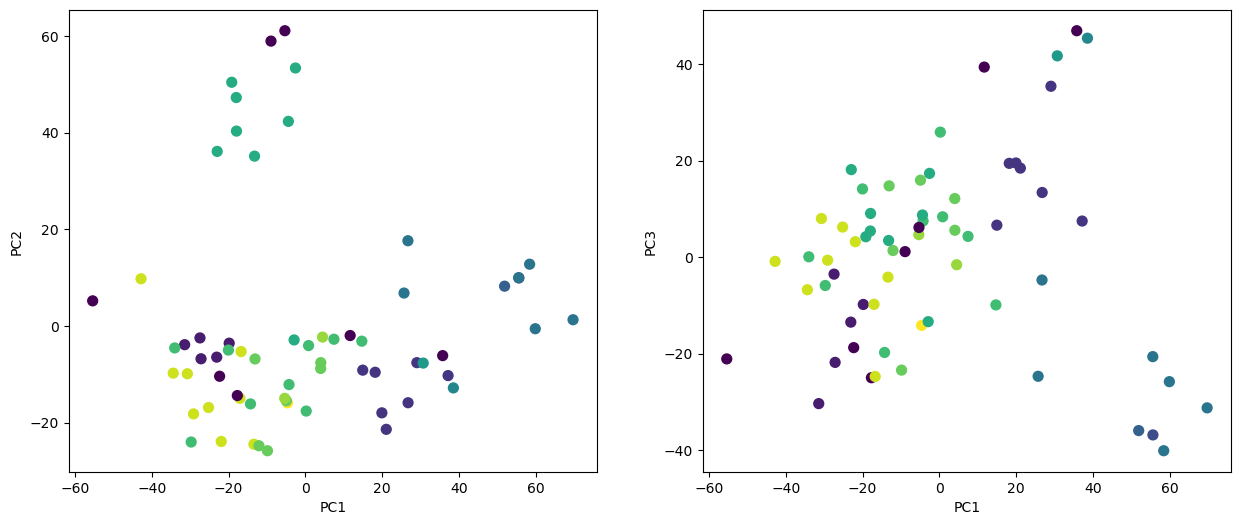

In [143]:
cancer_types = list(np.unique(nci_labs))
nci_groups = np.array([cancer_types.index(lab) for lab in nci_labs.values])
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes[0]
ax.scatter(
    nci_scores[:, 0],
    nci_scores[:, 1], 
    c=nci_groups,
    marker='o',
    s=50
)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

ax = axes[1]
ax.scatter(
    nci_scores[:, 0],
    nci_scores[:, 2],
    c=nci_groups,
    marker='o',
    s=50
)
ax.set_xlabel('PC1')
ax.set_ylabel('PC3');

Cell lines corresponding to a single cancer type do tend to have similar values on the first few principal component score vectors, indicating that cell lines from the same cancer type tend to have similar gne expression levels.

We also plot the percent variance explained by the principal components as well as the cumulative percent variance explained. 

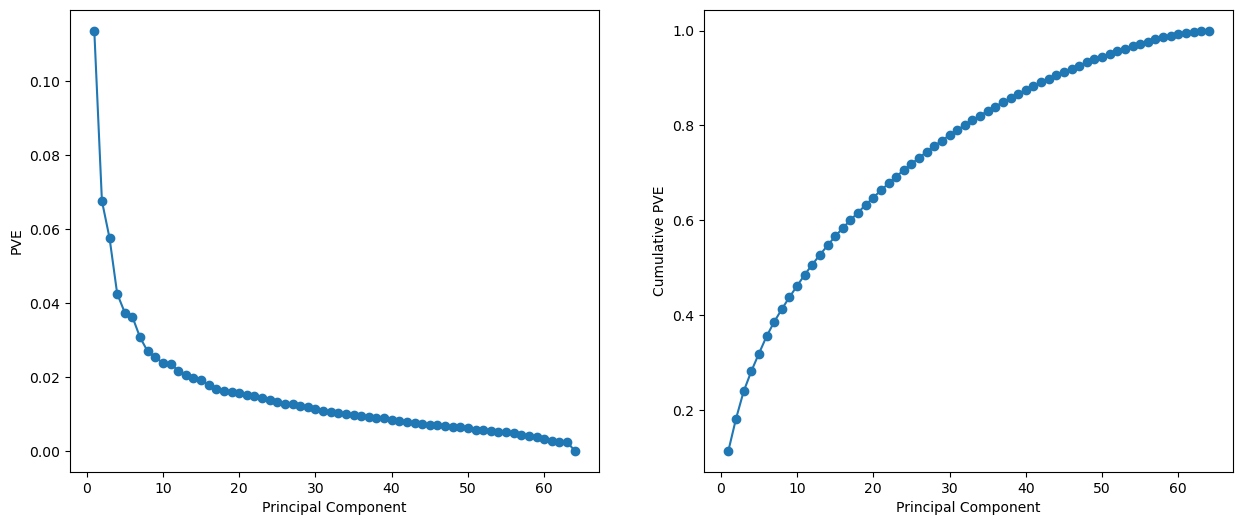

In [146]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes[0]
ticks = np.arange(nci_pca.n_components_)+1
ax.plot(
    ticks,
    nci_pca.explained_variance_ratio_,
    marker='o')
ax.set_xlabel('Principal Component')
ax.set_ylabel('PVE')

ax = axes[1]
ax.plot(
    ticks,
    nci_pca.explained_variance_ratio_.cumsum(),
    marker='o'
)
ax.set_xlabel('Principal Component')
ax.set_ylabel('Cumulative PVE');

We see that the first seven principal components account for about 40% of the variance in the data. This isn't a huge amount of variance, but the scree plot shows an elbow beginning at about the 7th component, suggesting that we don't gain much benefit by considering further components.

#### Clustering the Observations of the NCI60 Data

We perform hierarchical clustering of the cell lines in the NCI60 data using complete, single and average linkage. The goal is to find whether observations cluster into distinct types of cancer. We use euclidean distance as the dissimilarity measure.

In [150]:
def plot_nci(linkage, ax, cut=-np.inf):
    cargs = {'above_threshold_color': 'black',
             'color_threshold': cut}
    hc = HClust(
        n_clusters=None,
        distance_threshold=0,
        linkage=linkage.lower()
    ).fit(nci_scaled)
    linkage_ = compute_linkage(hc)
    dendrogram(
        linkage_,
        ax=ax,
        labels=np.asarray(nci_labs),
        leaf_font_size=10,
        **cargs
    )
    ax.set_title('%s Linkage' % linkage)
    return hc

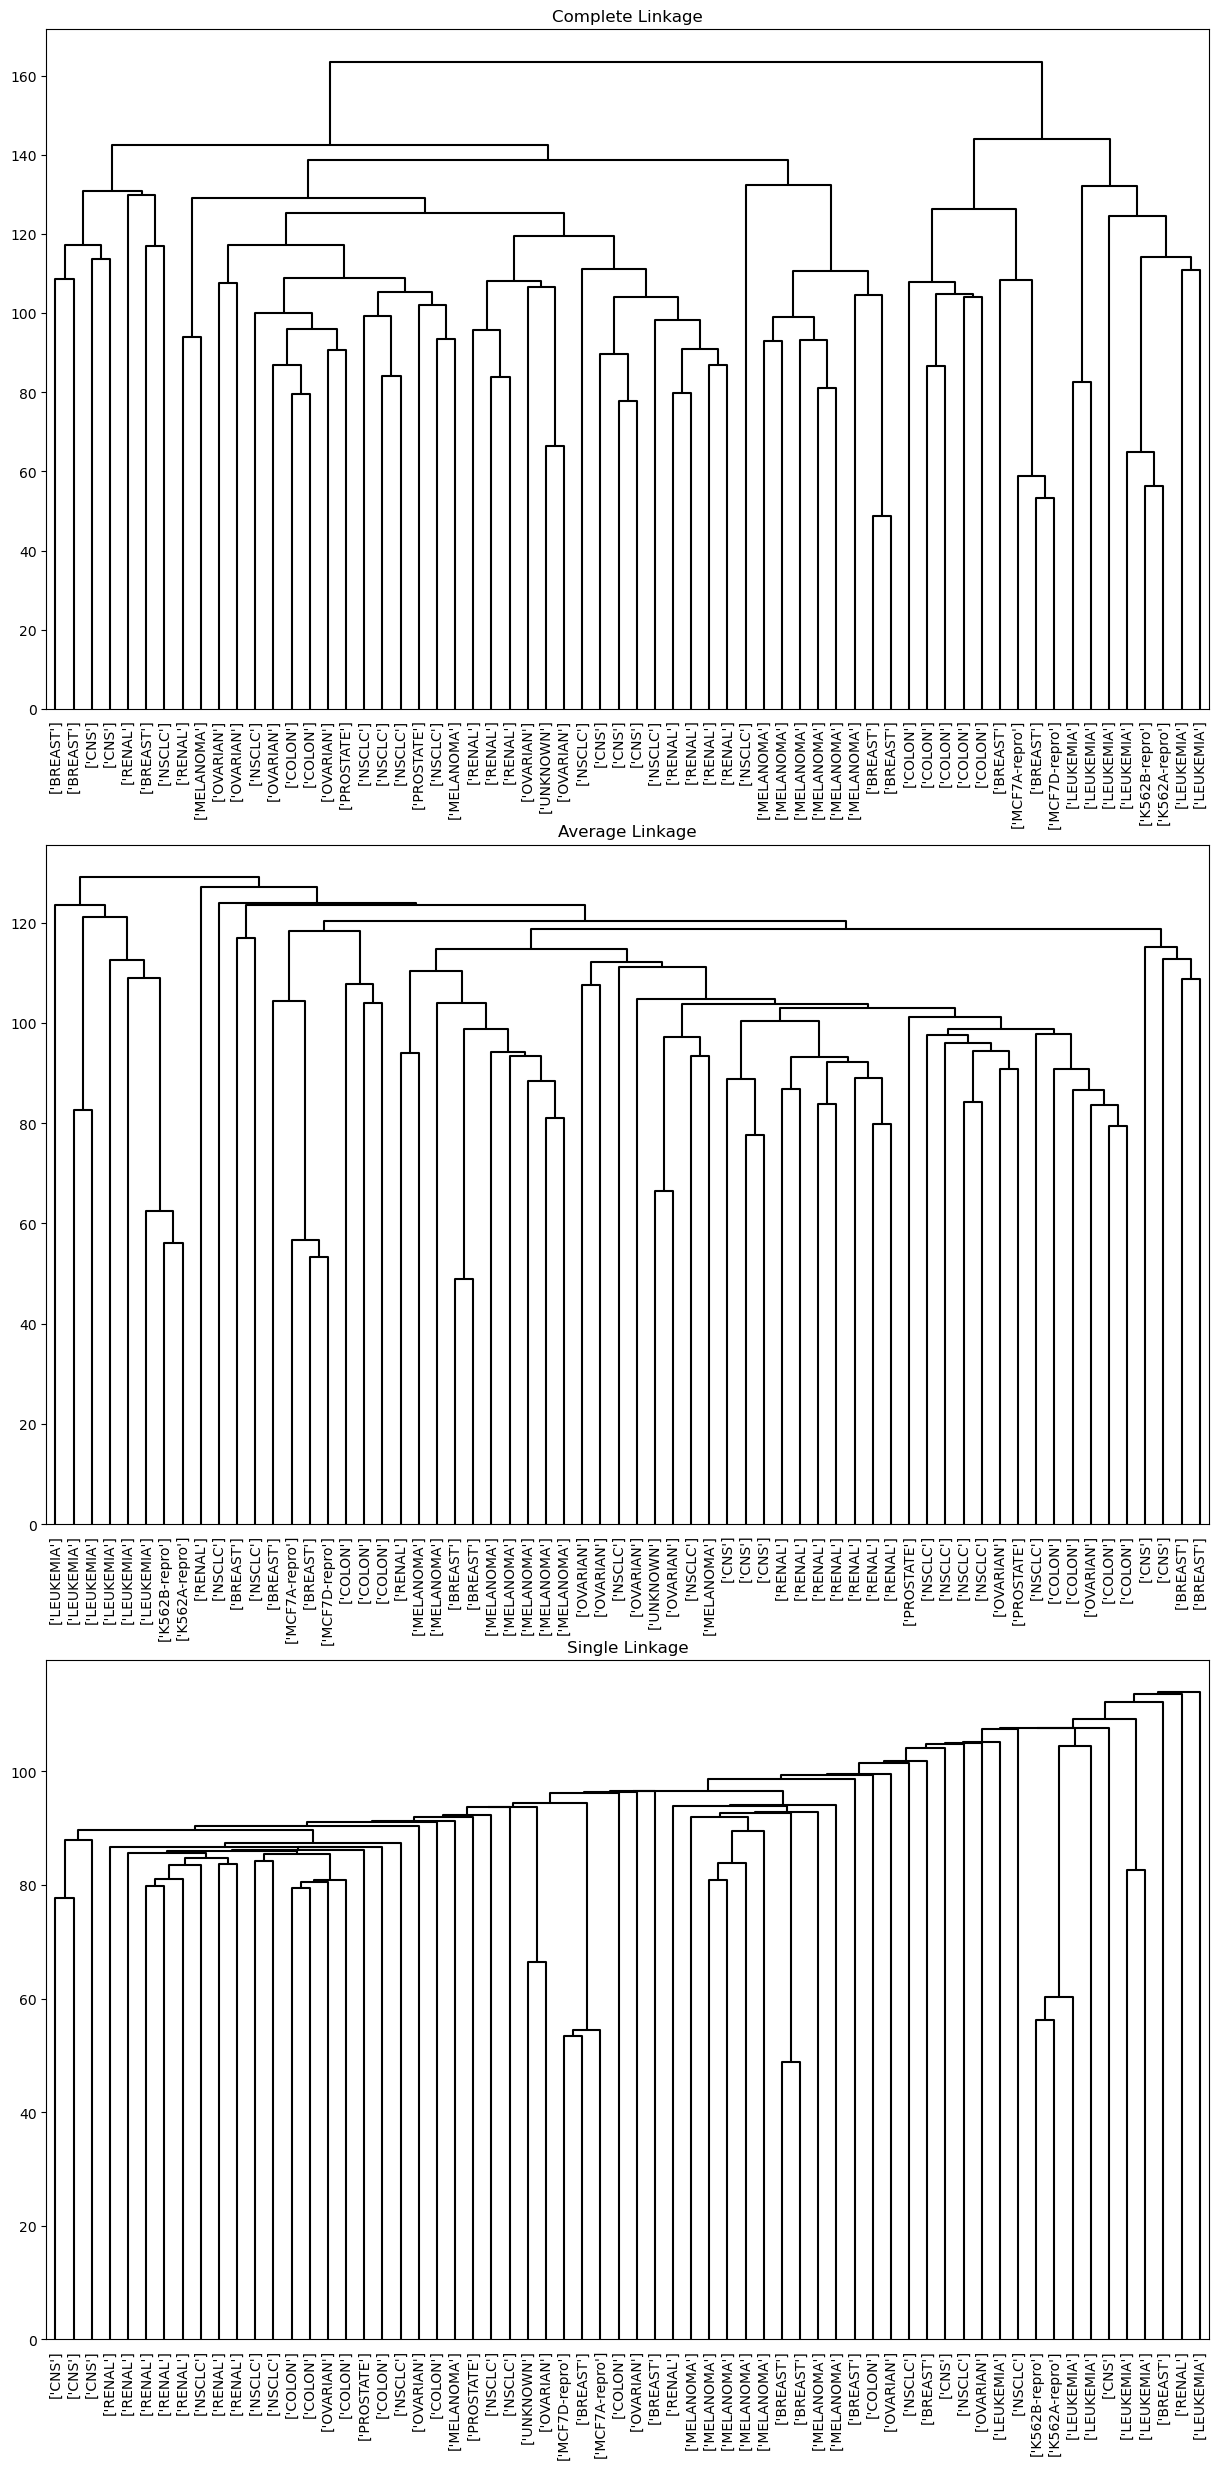

In [153]:
fig, axes = plt.subplots(3, 1, figsize=(15, 30))
ax = axes[0]; hc_comp = plot_nci('Complete', ax)
ax = axes[1]; hc_avg = plot_nci('Average', ax)
ax = axes[2]; hc_sing = plot_nci('Single', ax)

We see that single linkage tends to yield _trailing_ clusters: very large clusters to which individual observations attach one-by-one. For this reason, complete and average linkage are preferred.

We cut the complete linkage dendrogram at a height which yields 4 clusters:

In [154]:
linkage_comp = compute_linkage(hc_comp)
comp_cut = cut_tree(linkage_comp, n_clusters=4).reshape(-1)
pd.crosstab(
    nci_labs['label'],
    pd.Series(comp_cut.reshape(-1), name='Complete')
)

Complete,0,1,2,3
label,,,,
BREAST,2,3,0,2
CNS,3,2,0,0
COLON,2,0,0,5
K562A-repro,0,0,1,0
K562B-repro,0,0,1,0
LEUKEMIA,0,0,6,0
MCF7A-repro,0,0,0,1
MCF7D-repro,0,0,0,1
MELANOMA,8,0,0,0


There are some patterns: leukemia al fall into one cluster, in comparison to breast cancer which are spread out across three clusters.

We plot a cut on the dendrogram that produces these four clusters:

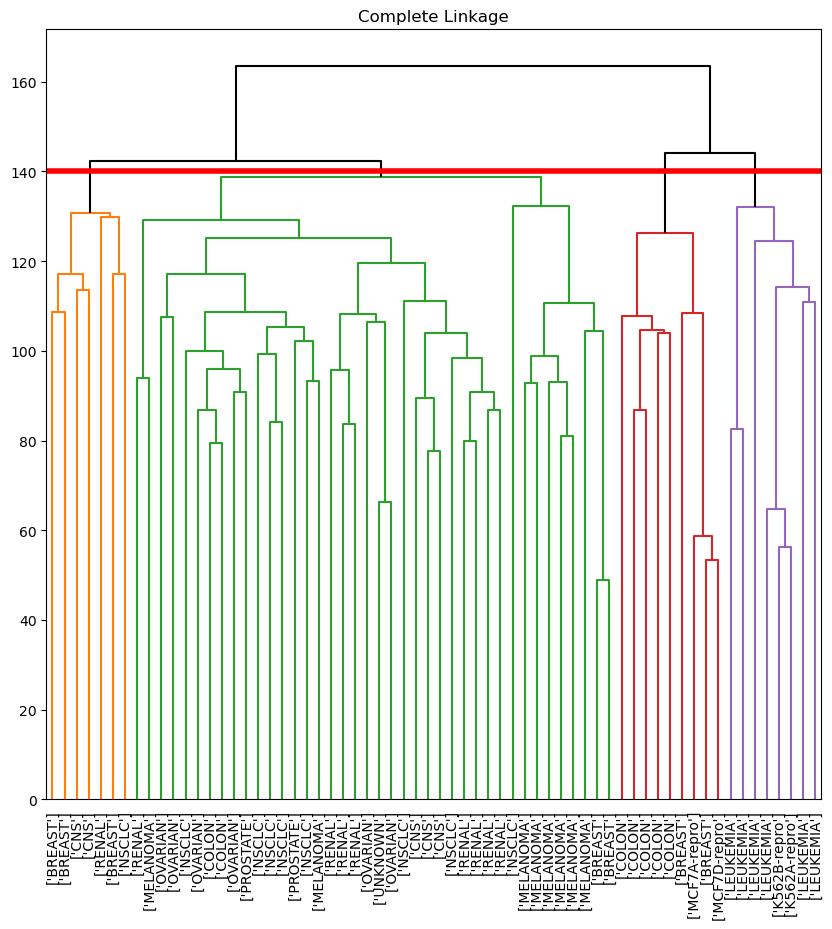

In [155]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_nci('Complete', ax, cut=140)
ax.axhline(140, c='r', linewidth=4);